In [1]:
import numpy as np
from scipy.signal import sepfir2d
from scipy import ndimage
from skimage import data, feature
import skimage
import matplotlib.pyplot as plt
plt.gray()
im = skimage.img_as_float(data.camera())

%matplotlib inline

# Edge Detection
The problem of edge detection aims to find "edges" in images. This is a hard quantity to define, so many methods consider edges to be areas with a high gradient. Possibly the simplest way to accomplish this would be to take the filter $k = [1, 0, -1]$ and its transpose (which represent a first order difference), convolve each of those with the image separately, and then take the sum of the pointwise squares of the results, which would be the magnitude of the gradient (squared). This approach is the one taken by Sobel edge detection, with the slight difference that the kernel takes into account the squares all squares to the side of the image. 
$$
k = \begin{pmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{pmatrix}
$$
Similar to the Sobel operator, the Scharr operator computes the same quantity, but with the values 3 and 10 instead of 1 and 2 (which increases rotational symmetry). Both of these are effective in low noise settings, but in noisier settings, it is more effective to blur the image first, so outliers are not thought to be edges. This is the concept used in the Canny edge detection algorithm, which first applies a blur to the image, followed by a Sobel or Scharr filter to detect edges. After this, non-maximum suppression is applied to the image, which is a technique to thin the edges, as one typically does not want to detect an edge many pixels wide. Then, a high and low threshold are applied, the pixels above the high threshold value are thought to definitely be edges, and the ones between low and high are labeled as uncertain. These uncertain edges are then passed to an algorithm to identify whether or not they are actually edges. Typically this is done by seeing if they are a continuation of an edge, or a point in the middle of a continuous color. If it is the former, they will usually be labeled as an edge, but if it is the latter, it is not. One disadvantage with the Canny algorithm is that there are a lot of parameters to tune: the size of the blur and the thresholds, in particular.

## Experiments
I use Scharr and Sobel edge detectors implemented by hand, and a Canny edge detection algorithm from a library. These are tested on the Cameraman image, as it has both smooth areas as well as nicely defined edges. I also examine the effect of Gaussian and Salt and Pepper noise on the different algorithms. I will use the Sobel filter on one example, but I will focus on the Scharr filter because of its superior practical properties

## Results
We can immediately see a difference on the noiseless image between a Scharr edge detector and a Canny: the Canny detector labels many many more pixels as edges. If we threshold the Scharr edge detector to try to get comparable detail, we see that the edges are much thicker. Using the Canny edge detector, we need to increase the spread of the initial blur as the size increases, as otherwise extreneous noise will be captured. We can also see that the Canny algorithm requires the last three steps. When we only blur and use edge detection on that, we find many values that are not edges with high gradient, seemingly offering no improvement over applying a Scharr detector with no blur.

In the case of salt in pepper noise, where each pixel is randomly assigned 0, 1, or its original value by a multinoulli distribution, where the probability of being assigned 0 is equal to the probability of being assigned 1, and the original value has probability $1-p$ of being assigned. We can see that there is significantly worse performance by the Scharr detector in this case, even if it is blurred before applying the algorithm. In contrast, the Canny algorithm detects the edges as before, but just not as many of them

In [2]:
def scharr_edges(im):
    k_h = np.array([1,0,-1])
    k_v = np.array([3,10,3])
    
    gx = sepfir2d(im, k_h, k_v)
    gy = sepfir2d(im, k_v, k_h)
    
    magnitudes = np.sqrt(gx**2+gy**2)
    return magnitudes
def sobel_edges(im):
    k_h = np.array([1,0,-1])
    k_v = np.array([1,2,1])
    
    gx = sepfir2d(im, k_h, k_v)
    gy = sepfir2d(im, k_v, k_h)
    
    magnitudes = np.sqrt(gx**2+gy**2)
    return magnitudes
def gnoise(im, std):
    M = im.max()
    m = im.min()
    return np.clip(im + np.random.randn(*im.shape)*std, m, M)
def spnoise(im, p):
    r = np.random.rand(*im.shape)
    l = r<p/2
    u = r>1-p/2
    o = 1-l*u
    return im*o + u

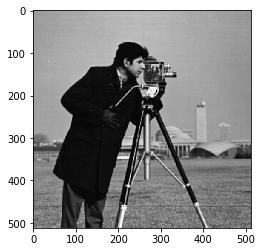

In [3]:
plt.imshow(im)

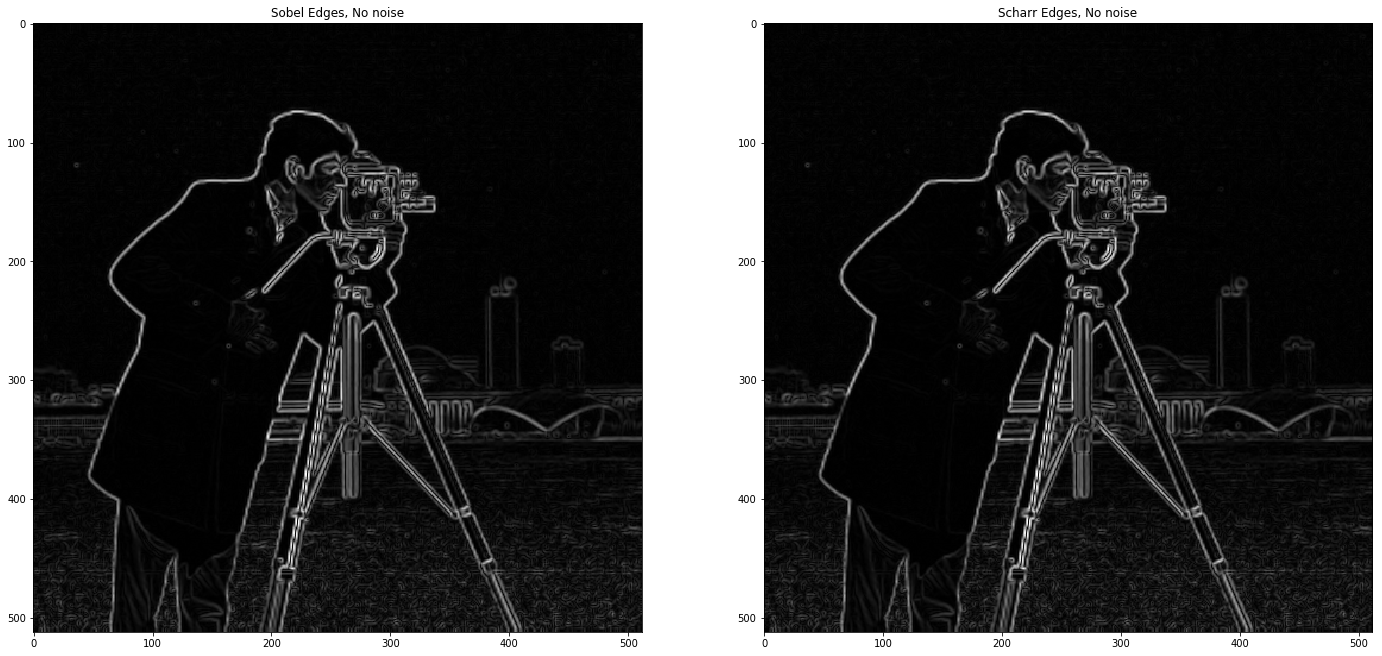

In [4]:
plt.figure(figsize=(24,12))
ax = plt.subplot(1,2,1)
ax.set_title('Sobel Edges, No noise')
ax.imshow(sobel_edges(im))

ax = plt.subplot(1,2,2)
ax.set_title('Scharr Edges, No noise')
ax.imshow(scharr_edges(im))

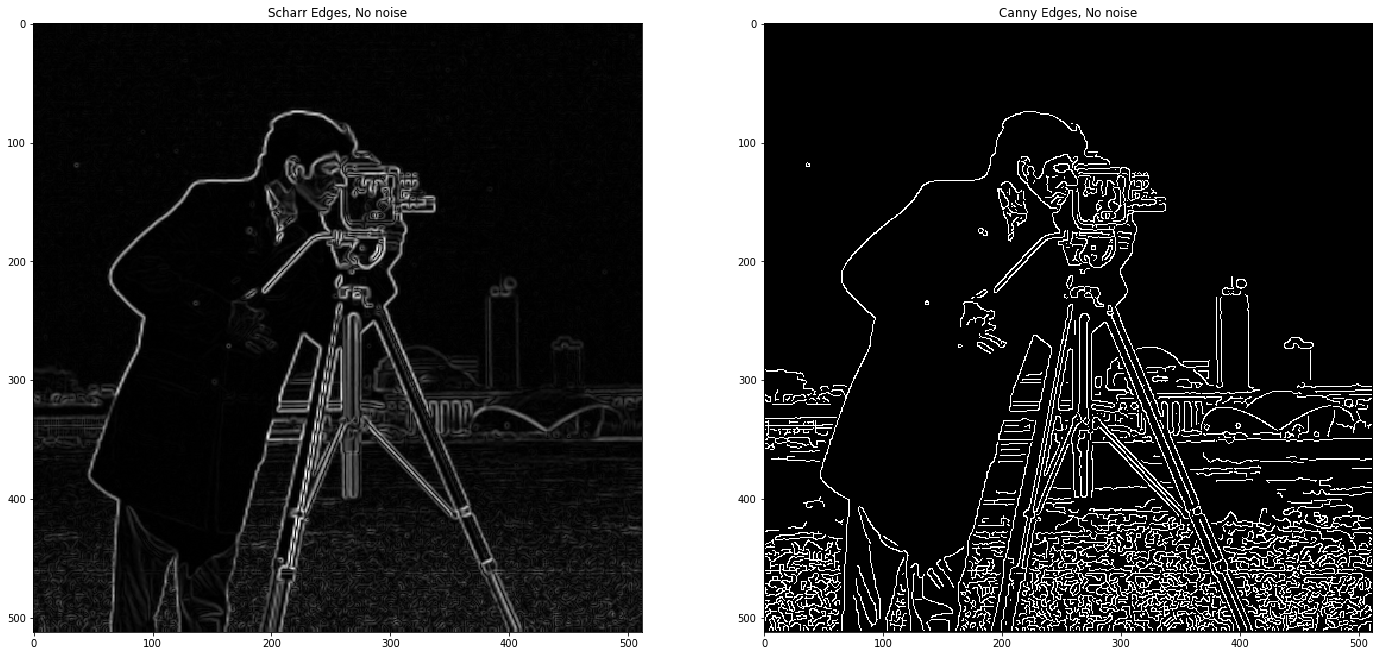

In [5]:
plt.figure(figsize=(24,12))
ax = plt.subplot(1,2,1)
ax.set_title('Scharr Edges, No noise')
ax.imshow(scharr_edges(im))

ax = plt.subplot(1,2,2)
ax.set_title('Canny Edges, No noise')
ax.imshow(feature.canny(im))

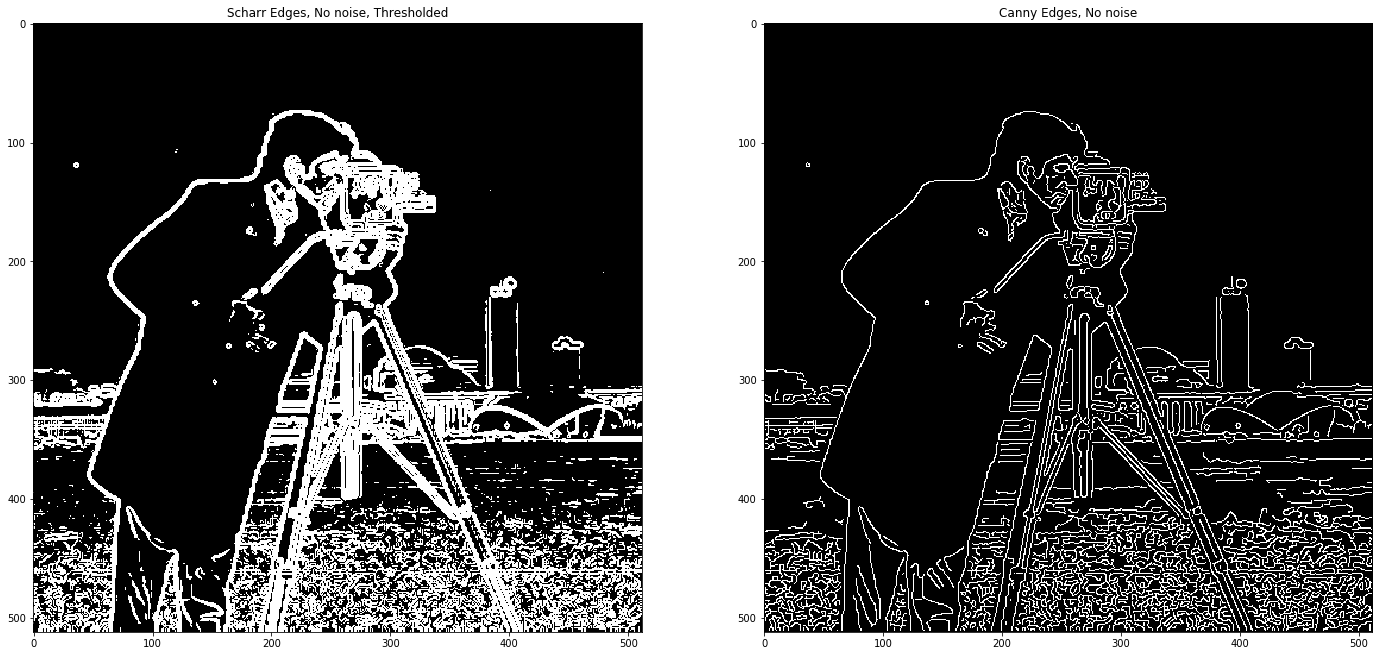

In [6]:
plt.figure(figsize=(24,12))
ax = plt.subplot(1,2,1)
ax.set_title('Scharr Edges, No noise, Thresholded')
ax.imshow(scharr_edges(im)>1)

ax = plt.subplot(1,2,2)
ax.set_title('Canny Edges, No noise')
ax.imshow(feature.canny(im))

## Gaussian Noise

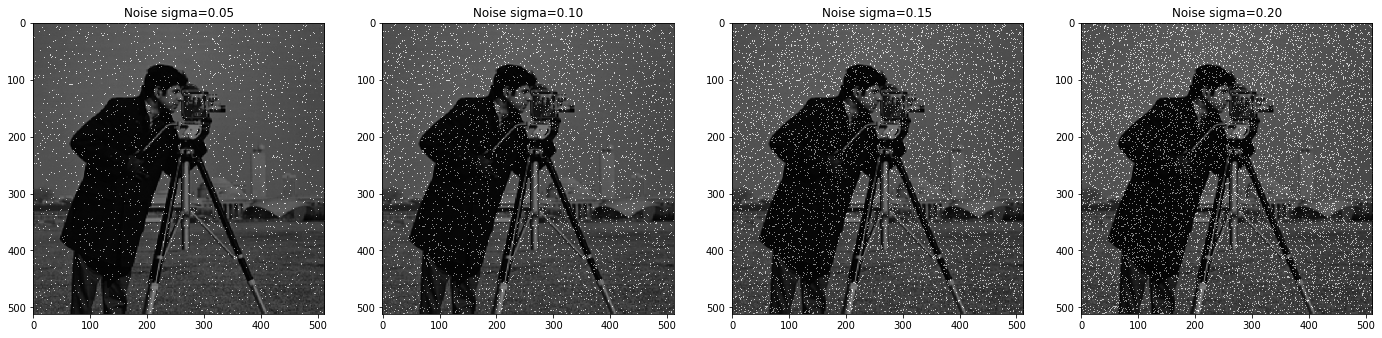

In [7]:
fig = plt.figure(figsize=(24,24))

noise_sigmas = np.arange(0.05, 0.25, 0.05)
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas) ,ct)
    e = (spnoise(im, noise_sigmas[i]))
    ax.imshow(e)
    ax.set_title('Noise sigma=%.2f'%(noise_sigmas[i]))    

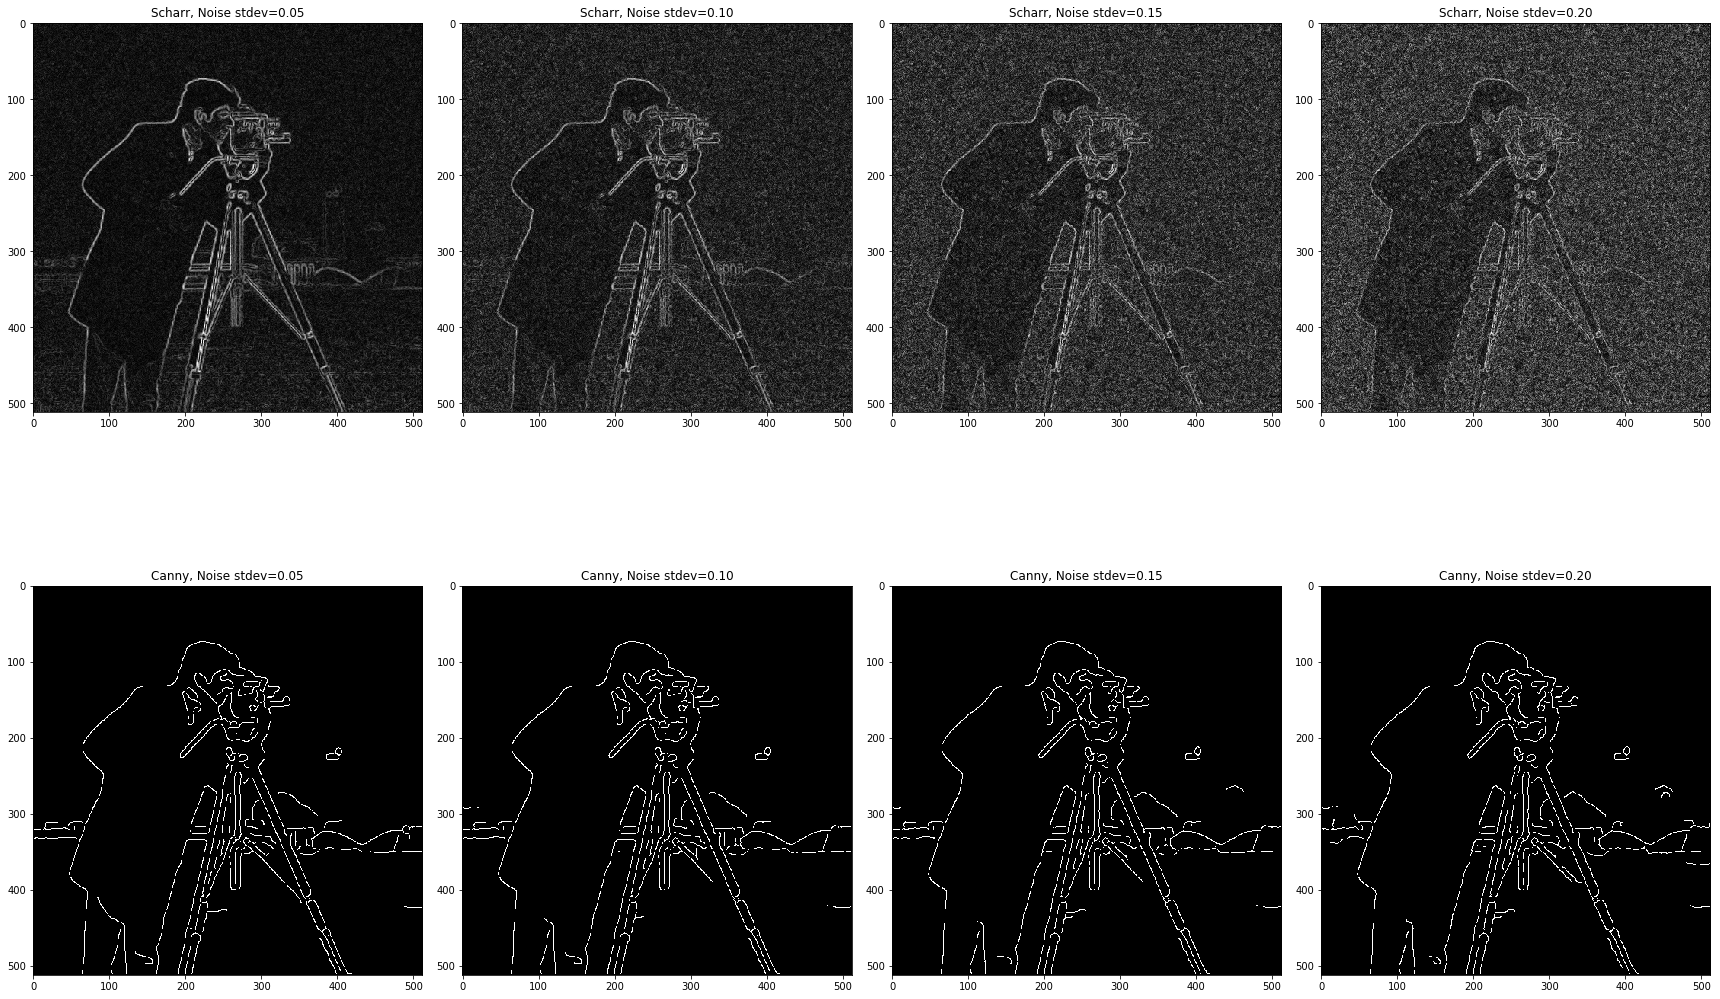

In [8]:
# Gaussian different sigma
fig = plt.figure(figsize=(24,24))

noise_sigmas = np.arange(0.05, 0.25, 0.05)
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas) ,ct)
    e = scharr_edges(gnoise(im, noise_sigmas[i]))
    ax.imshow(e)
    ax.set_title('Scharr, Noise stdev=%.2f'%(noise_sigmas[i]))
    
for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas), ct)
    e = feature.canny(gnoise(im, noise_sigmas[i]), sigma=3)
    ax.imshow(e)
    ax.set_title('Canny, Noise stdev=%.2f'%(noise_sigmas[i]))


fig.set_facecolor('w')
plt.tight_layout()

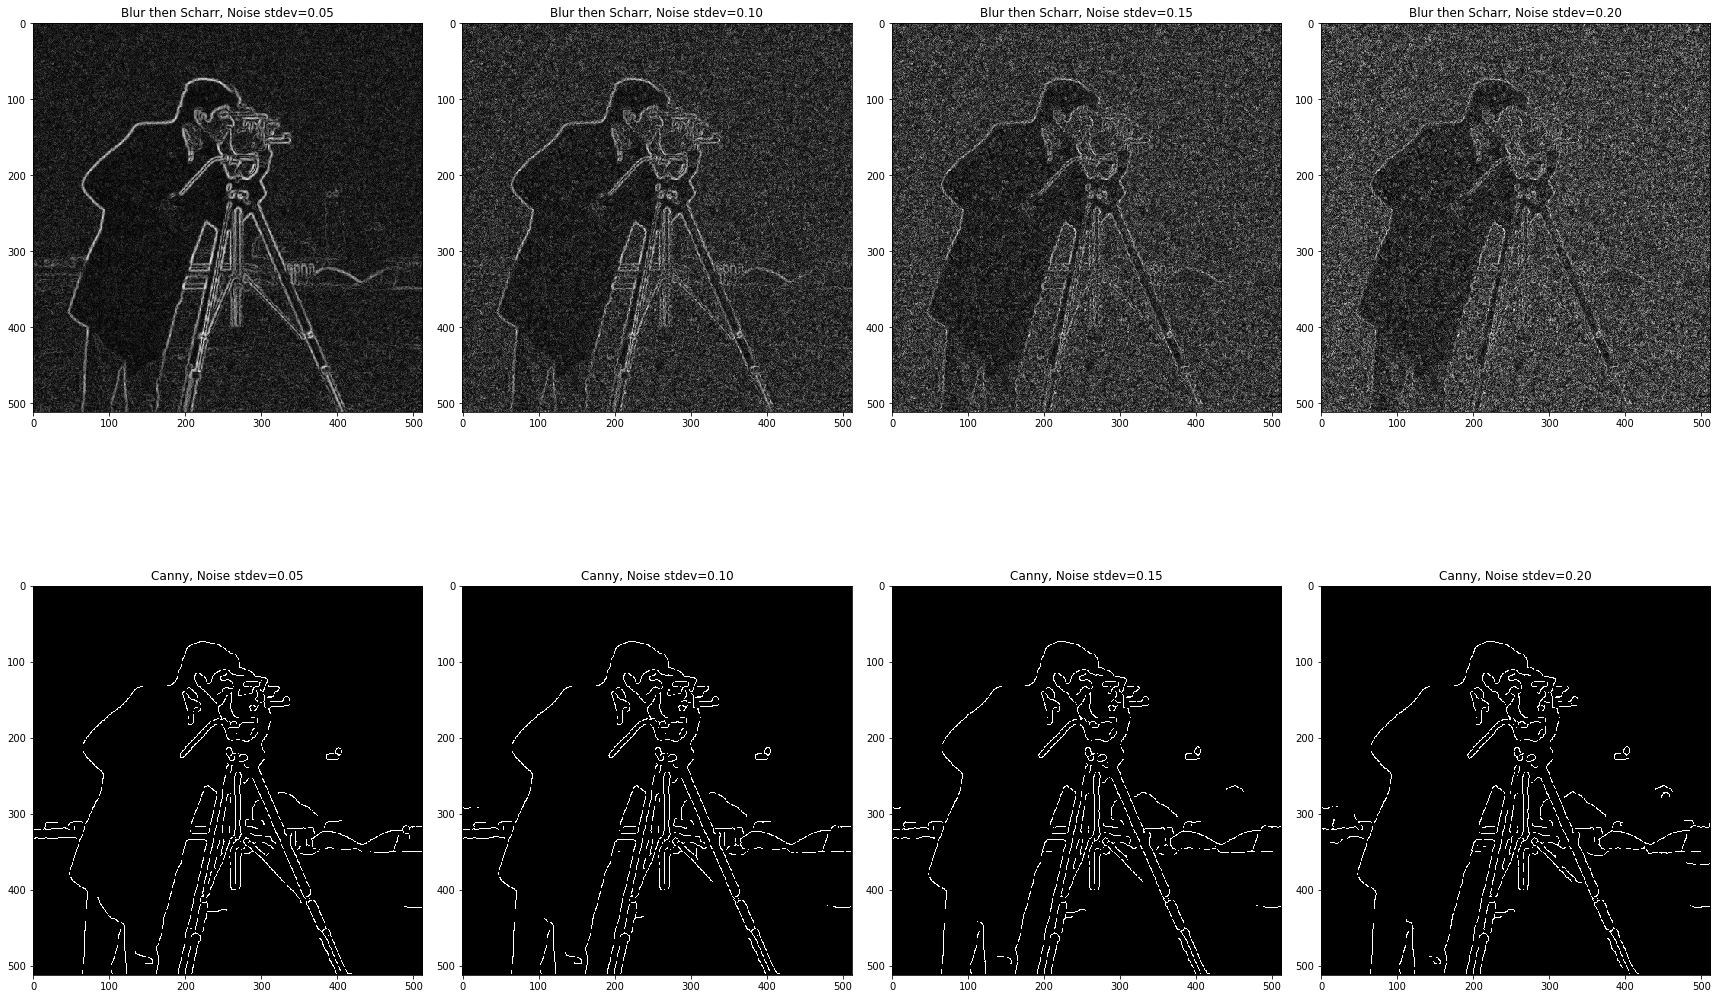

In [9]:
# Gaussian different sigma
fig = plt.figure(figsize=(24,24))

noise_sigmas = np.arange(0.05, 0.25, 0.05)
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas) ,ct)
    e = scharr_edges(gnoise(ndimage.gaussian_filter(im, 1), noise_sigmas[i]))
    ax.imshow(e)
    ax.set_title('Blur then Scharr, Noise stdev=%.2f'%(noise_sigmas[i]))    
    
for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas), ct)
    e = feature.canny(gnoise(im, noise_sigmas[i]), sigma=3)
    ax.imshow(e)
    ax.set_title('Canny, Noise stdev=%.2f'%(noise_sigmas[i]))


fig.set_facecolor('w')
plt.tight_layout()

## S&P Noise

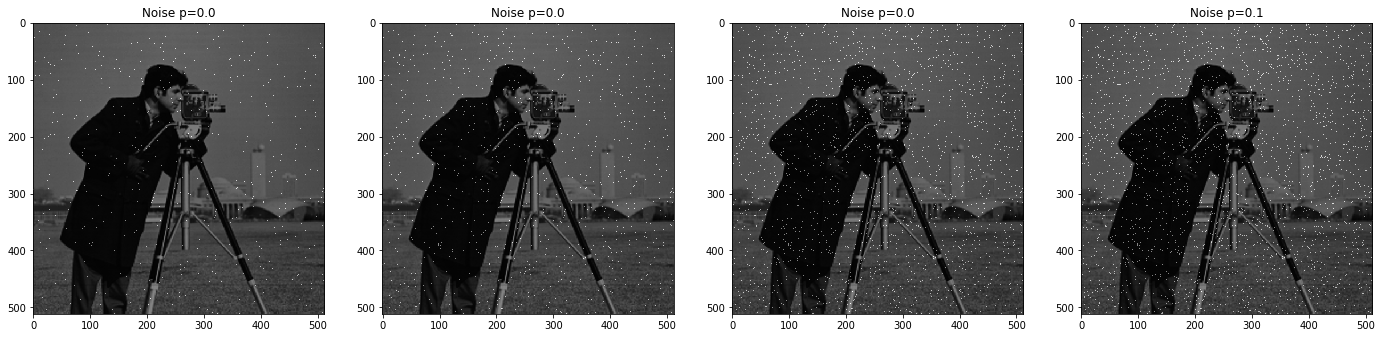

In [10]:
fig = plt.figure(figsize=(24,24))

noise_sigmas = [0.01, 0.02, 0.04, 0.05]
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas) ,ct)
    e = (spnoise(im, noise_sigmas[i]))
    ax.imshow(e)
    ax.set_title('Noise p=%.1f'%(noise_sigmas[i]))    

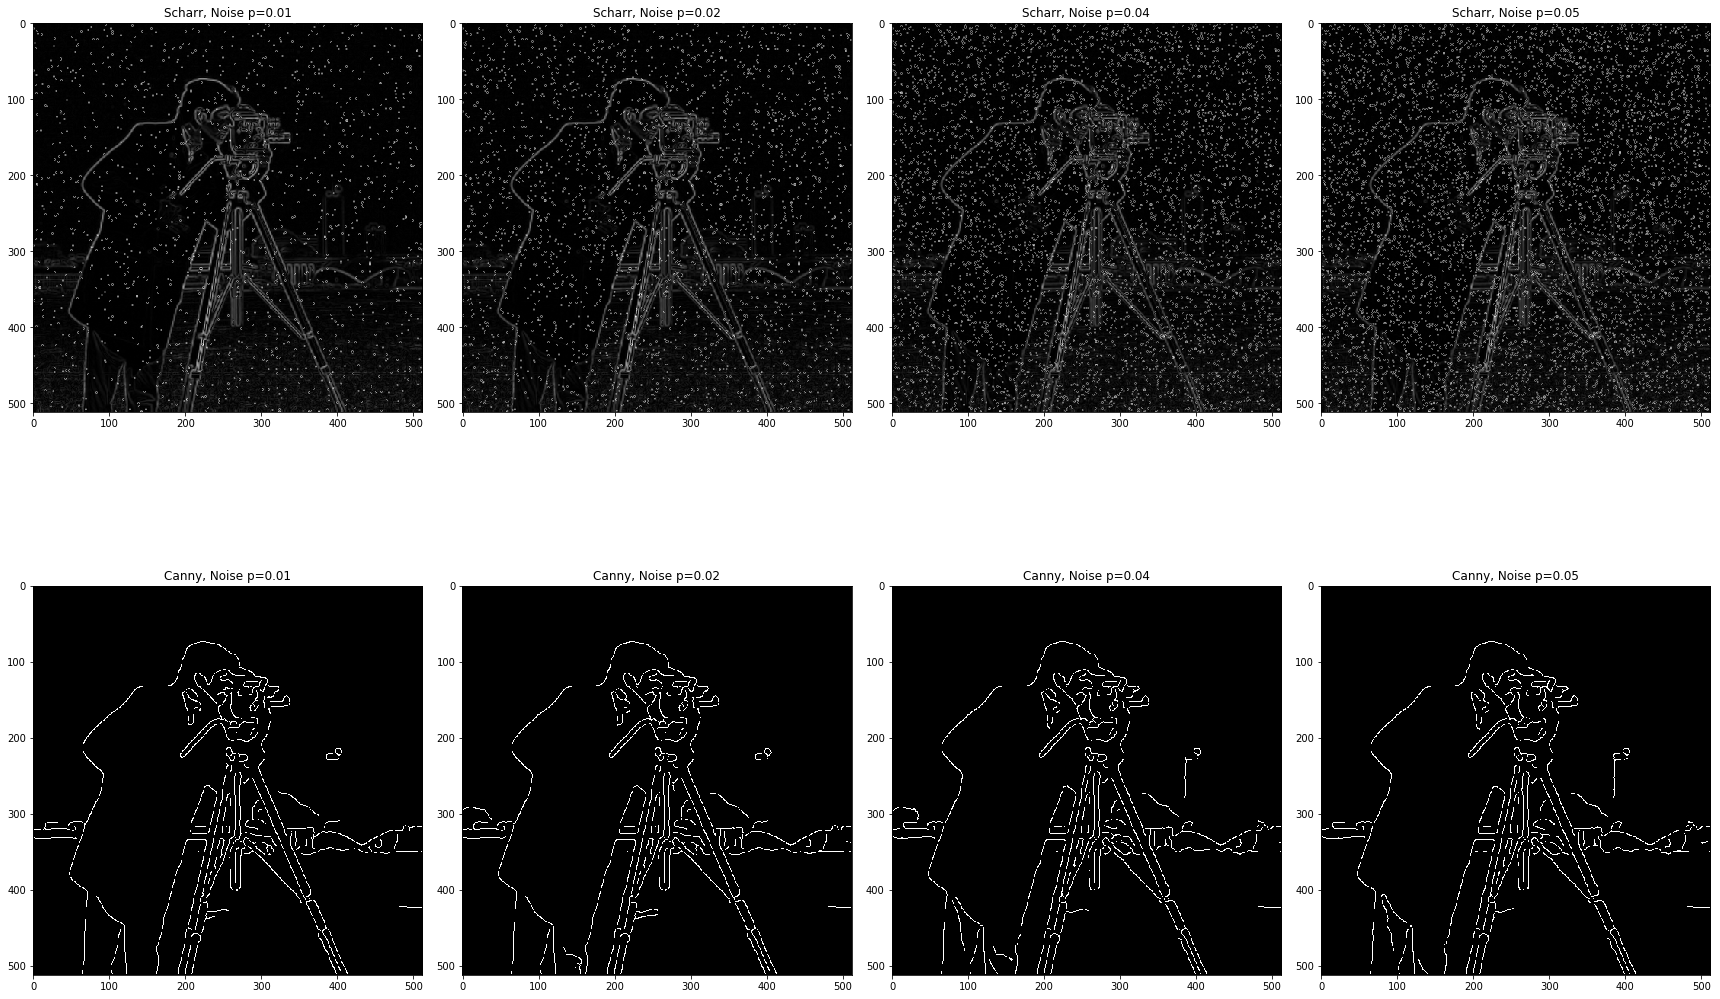

In [11]:
# Gaussian different sigma
fig = plt.figure(figsize=(24,24))

noise_sigmas = [0.01, 0.02, 0.04, 0.05]
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas) ,ct)
    e = scharr_edges(spnoise(im, noise_sigmas[i]))
    ax.imshow(e)
    ax.set_title('Scharr, Noise p=%.2f'%(noise_sigmas[i]))
    
for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas), ct)
    e = feature.canny(spnoise(im, noise_sigmas[i]), sigma=3)
    ax.imshow(e)
    ax.set_title('Canny, Noise p=%.2f'%(noise_sigmas[i]))


fig.set_facecolor('w')
plt.tight_layout()

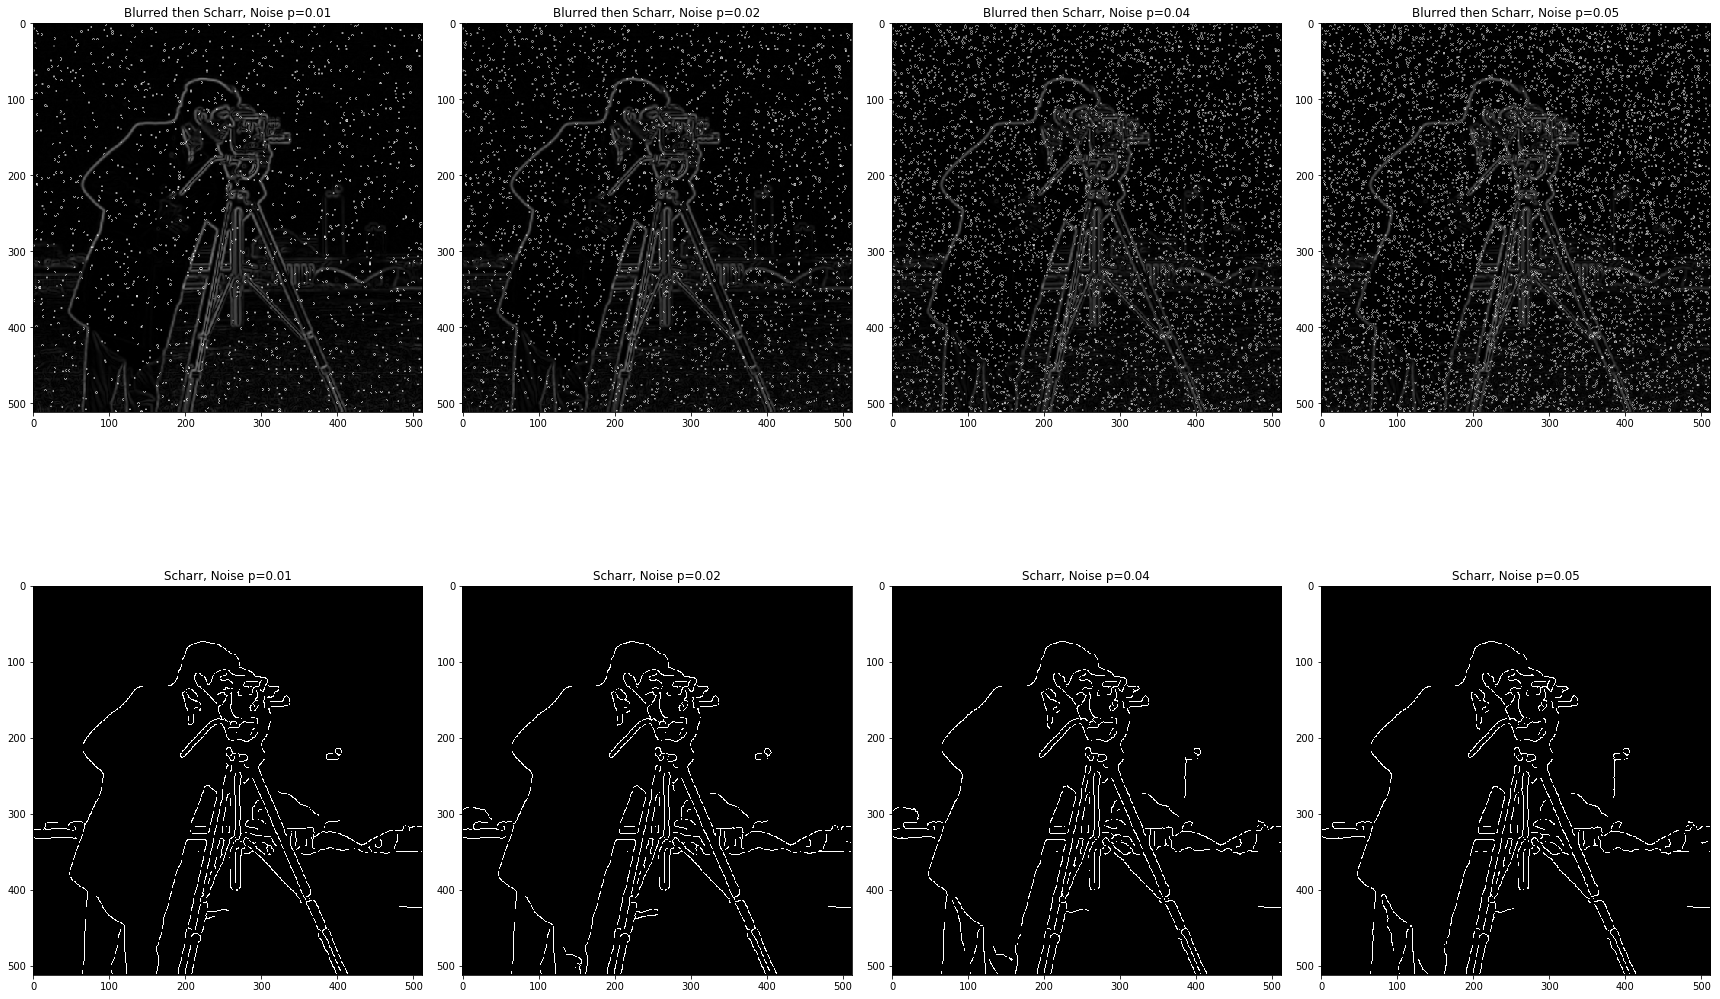

In [12]:
# Gaussian different sigma
fig = plt.figure(figsize=(24,24))

noise_sigmas = [0.01, 0.02, 0.04, 0.05]
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas) ,ct)
    e = scharr_edges(spnoise(ndimage.gaussian_filter(im, 1), noise_sigmas[i]))
    ax.imshow(e)
    ax.set_title('Blurred then Scharr, Noise p=%.2f'%(noise_sigmas[i]))    
    
for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(3, len(noise_sigmas), ct)
    e = feature.canny(spnoise(im, noise_sigmas[i]), sigma=3)
    ax.imshow(e)
    ax.set_title('Scharr, Noise p=%.2f'%(noise_sigmas[i]))


fig.set_facecolor('w')
plt.tight_layout()